Run this to mount your personal google drive.
Ensure you have COCO-Human-Pose repo cloned into your drive at the path on line 6.

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Switch directories
%cd /content/gdrive/MyDrive/Colab\ Data/COCO-Human-Pose
%ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Data/COCO-Human-Pose
COCO-Dataset/  data_generator.py    LICENSE     output/           submodules/
coco_df.py     evaluation.py        logs/       README.md         test.py
constants.py   hourglass_blocks.py  models/     requirements.txt  train.py
data/          hourglass.py         notebooks/  scripts/


In [3]:
!ls /content/gdrive/MyDrive/

 beamer_blue.rar
'Canadian Engineering Competition 2020 (CEC)'
'Canadian Intern Situation.gdoc'
'CENG 241 Lab Reports'
 COCO
'Coco Battery Depreciation.gform'
'Coco Battery Depreciation (Responses).gsheet'
'Colab Data'
'Colab Notebooks'
'Copy of Budget 2019 Public 2.gsheet'
'Copy of Example Budget for 2021.gsheet'
'Copy of Example Google Form for 2021 (1).gform'
'Copy of Example Google Form for 2021.gform'
'Copy of Free Four Phase SEO Audit Template Copy.gsheet'
'Copy of Grad School: Frequently Asked Questions.gdoc'
'Copy of Local SEO Free Template.gsheet'
'Copy of Negative Placements List.gsheet'
'Copy of Norbert'\''s Gambit on Questrade: Calculate Commission & ECN Fees (wealthsavvy.ca).gsheet'
'Copy of Options and ETFs.gslides'
'Copy of Portfolio Management & Stock Screening.gsheet'
'Copy of RBC_UVic ENGR Opener.mp4'
'Copy of Return Offers 2020 (Responses).gsheet'
'Copy of Tesla Model 3 Delivery Checklist.gsheet'
'Copy of TikTok Recipes.gdoc'
'ECE 350 Project'
'ECE 356 Project'
'ECE 

Run this to load coco train/val keypoint annotations into an in-mem dataframe which can be queried. Ensure the paths make sense.

In [4]:
# Run this block ONCE to load train and val annotations into mem and
# and create a useful df where each row is an annotation (person/crowd) instance
from pycocotools.coco import COCO
import numpy as np
import pandas as pd
import skimage.io as io
import matplotlib.pyplot as plt

train_annot_path = '/content/gdrive/MyDrive/COCO/2017/annotations/person_keypoints_train2017.json'
val_annot_path = '/content/gdrive/MyDrive/COCO/2017/annotations/person_keypoints_val2017.json'
train_coco = COCO(train_annot_path) # load annotations for training set
val_coco = COCO(val_annot_path) # load annotations for validation set

def get_meta(coco):
    ids = list(coco.imgs.keys())
    for i, img_id in enumerate(ids):
        img_meta = coco.imgs[img_id]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        img_file_name = img_meta['file_name']
        w = img_meta['width']
        h = img_meta['height']
        
        yield [img_id, img_file_name, w, h, anns]
        
def convert_to_df(coco):
    images_data = []
    persons_data = []
    
    for img_id, img_fname, w, h, meta in get_meta(coco):
        images_data.append({
            'image_id': int(img_id),
            'src_set_image_id': int(img_id), # repeat id to reference after join
            'path': img_fname,
            'width': int(w),
            'height': int(h)
        })
        for m in meta: 
            persons_data.append({
                'image_id': m['image_id'],
                'is_crowd': m['iscrowd'],
                'bbox': m['bbox'],
                'area': m['area'],
                'num_keypoints': m['num_keypoints'],            
                'keypoints': m['keypoints'],
                'segmentation': m['segmentation']
            })
    
    images_df = pd.DataFrame(images_data) 
    images_df.set_index('image_id', inplace=True)

    persons_df = pd.DataFrame(persons_data) 
    persons_df.set_index('image_id', inplace=True)
    
    return images_df, persons_df

images_df, persons_df = convert_to_df(train_coco)     
train_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)
train_coco_df['source'] = 0
train_coco_df.head()

images_df, persons_df = convert_to_df(val_coco)      
val_coco_df = pd.merge(images_df, persons_df, right_index=True, left_index=True)
val_coco_df['source'] = 1
val_coco_df.head()

coco_df = pd.concat([train_coco_df, val_coco_df], ignore_index=True)
# ^ Dataframe containing all val and test keypoint annotations

loading annotations into memory...
Done (t=12.02s)
creating index...
index created!
loading annotations into memory...
Done (t=1.04s)
creating index...
index created!


Run this to declare a function that displays Image w/ annotations by file name

In [ ]:
# Filename is a globally unique identifier among all train/val/test splits
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
from matplotlib.patches import Rectangle
pylab.rcParams['figure.figsize'] = (30.0, 30.0)

def display_img(image_file_name):
  # Determine if img exists and if it is in train or val set
  img_df_rows = coco_df.loc[coco_df['path'] == image_file_name]
  if len(img_df_rows) == 0:
    print("Image with filename: " + image_file_name + " does not exist.")
  else:
    coco = train_coco if img_df_rows['source'].iloc[0] == 0 else val_coco

    # Get img id from file name
    imgId = img_df_rows['src_set_image_id'].iloc[0]
    img = coco.imgs[imgId]
    I = io.imread(img['coco_url']) # load image from URL (no need to store image locally)

    # load and display keypoints annotations
    plt.subplot(1,2,1)
    plt.imshow(I)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.imshow(I)
    annIds = coco.getAnnIds(imgIds=[imgId])
    anns = coco.loadAnns(annIds)
    bbox= anns[0]['bbox']
    plt.gca().add_patch(Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],
                    edgecolor='red',
                    facecolor='none',
                    lw=4))
    coco.showAnns(anns)
    plt.show()

Example of using the display_img function

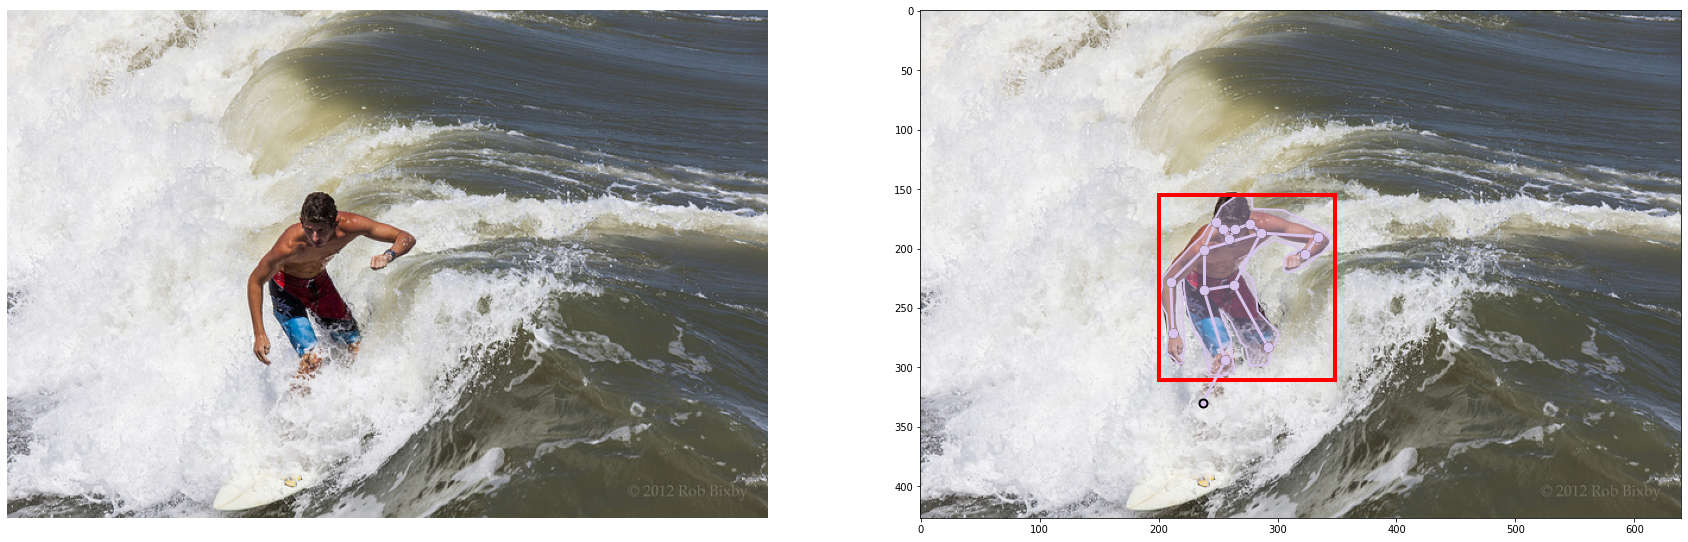

In [ ]:
image_file_name = '000000163171.jpg'
display_img(image_file_name)

In [ ]:
# see the contents of the coco-df
coco_df[coco_df['path'] == '000000163171.jpg']['bbox']

73601    [200.1, 155.1, 148.39, 155.1]
Name: bbox, dtype: object

# All code blocks below are example queries on the coco df.

In [ ]:
# Number of images in train + val
len(coco_df.groupby('path',as_index=False).size())

In [ ]:
# Breakdown of num images with a given num annotations
coco_df.groupby('path',as_index=False).size().rename(columns = {'size': 'num_annotations'}).groupby('num_annotations',as_index=False).size().rename(columns={'size':'num_images'}).sort_values(by='num_images',ascending=False)

In [ ]:
# images with crowds
coco_df.loc[coco_df['is_crowd'] == 1].groupby('path', as_index=False).size()

In [ ]:
# Breakdown of num of annotations with a given num keypoints
coco_df.groupby('num_keypoints',as_index=False).size().sort_values(by='size',ascending=False)

In [ ]:
# Annotations with X keypoints
coco_df.loc[coco_df['num_keypoints'] == 0]

In [ ]:
# The image with the most people (20)
coco_df.groupby('path',as_index=False).size().loc[coco_df.groupby('path',as_index=False).size()['size'] == 20]

In [ ]:
# how many images have an annotation with x or more keypoints?
# how many of those images have only one annotation?

# num images where best annotation has X keypoints
df = coco_df.groupby('path',as_index=False).max('num_keypoints').groupby('num_keypoints',as_index=False).size()

# increase sizes so that sum represents all images with X or MORE keypoints
for i, row in df.iterrows():
  row['size'] += sum(df.loc[df['num_keypoints'] > row['num_keypoints']]['size'])

df.rename(columns={'size':'num_imgs'},inplace=True)

anns_per_img = coco_df.groupby('path',as_index=False).size()
imgs_w_one_ann = anns_per_img.loc[anns_per_img['size'] == 1]
imgs_w_one_ann = pd.merge(imgs_w_one_ann,coco_df)
df2 = imgs_w_one_ann.groupby('num_keypoints',as_index=False).size()

# increase sizes so that sum represents all images with X or MORE keypoints
for i, row in df2.iterrows():
  row['size'] += sum(df2.loc[df['num_keypoints'] > row['num_keypoints']]['size'])

df2.rename(columns={'size':'num_imgs_with_only_one_ann'},inplace=True)

pd.merge(df,df2)

In [ ]:
## major questions ##
# how will model handle images with more than one person?
# how will model handle images with half a person/person far away? (will num outputted keypoints be constant or dynamic?)